In [1]:
from google.colab import drive
import os
import json
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
import matplotlib.pyplot as plt
from keras.datasets import mnist
import tensorflow as tf

def plot_history(history, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  # Be careful because the axis ranges are automatically adapted
  # which may not desirable to compare different runs.
  # Also, in some cases you may want to combine several curves in one
  # figure for easier comparison, which this function does not do.
  
  if metric != None:
    fig, axes = plt.subplots(2,1)
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Train', 'Val'])
    except:
      pass
    axes[0].set_title('{:s}'.format(metric))
    axes[0].set_ylabel('{:s}'.format(metric))
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Train', 'Val'])
    except:
      pass
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  


In [ ]:
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Deep Learning 2021/Notebook Four - Common CNN Architecture")
!ls

# **Coursework**

## Classification on Tiny-ImageNet

In this task, we are going to explore different models to do classification on 64x64 Tiny-ImageNet. Tiny-ImageNet is a smaller version of ImageNet (as the name indicates), containing "only" 200 classes. Each class has 500 images. The test set contains 10,000 images. All images are 64x64 RGB images. 

In the Network Training notebook, we explained how to define a validation set, and now we will put that into practice. Hence, as we now have a bigger dataset, we are going to use the standard split of training, validation, and test data. Therefore, you will check the performance of the network in the validation set while training your network. Hence, your decisions need to be based on validation performance. Once you have obtained your best model using the training and validation data, you need to report the performance on the test set. Please try to no overfit to the test data, as in other problems it may not be available to you. 

In this exercise, you are asked to train VGG models with different strategies. Optionally, you are asked to use any other architecture of your choice to do classification in Tiny-ImageNet. 

Run the following script to get the data. 




fatal: destination path 'IMagenet' already exists and is not an empty directory.
starting loading data
finished loading data, in 12.353955268859863 seconds


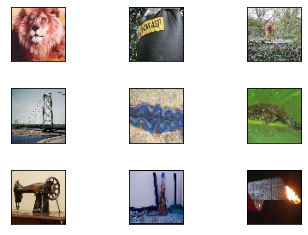

In [ ]:
from keras import backend as K
import scipy.ndimage as nd
from keras.models import Sequential,load_model
from keras import regularizers
from keras import initializers
from keras import metrics
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Convolution2D, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU 
from keras import layers
from keras import models
from keras.optimizers import Adam
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt

# download TinyImageNet
! git clone https://github.com/seshuad/IMagenet

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])
        
    return result

def get_data(id_dict):

    print('starting loading data')
    train_data, val_data, test_data = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450)]
        
        train_labels_ = np.array([[0]*200]*450)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()
        
        val_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450, 500)]
        
        val_labels_ = np.array([[0]*200]*50)
        val_labels_[:, value] = 1
        val_labels += val_labels_.tolist()

    for line in open('IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread('IMagenet/tiny-imagenet-200/val/images/{}'.format(img_name)))

        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))

    return np.array(train_data), np.array(train_labels), np.array(val_data), np.array(val_labels), np.array(test_data), np.array(test_labels)
  
def shuffle_data(train_data, train_labels, val_data, val_labels):
    # This function shuffles separately the train set and the 
    # validation set
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)
    
    size = len(val_data)
    val_idx = np.arange(size)
    np.random.shuffle(val_idx)

    return train_data[train_idx], train_labels[train_idx], val_data[val_idx], val_labels[val_idx]

train_data, train_labels, val_data, val_labels, test_data, test_labels = get_data(get_id_dictionary())
train_data, train_labels, val_data, val_labels = shuffle_data(train_data, train_labels, val_data, val_labels)

# Let's visualize some examples
N=3
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col    
    tmp = cv2.cvtColor(train_data[idx],cv2.COLOR_BGR2RGB)
    axes[row,col].imshow(tmp, cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

train_data = train_data.astype('float32') / 255.
val_data = val_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data, axis=(0, 1, 2, 3))
train_data = (train_data-mean)/(std+1e-7)
val_data = (val_data-mean)/(std+1e-7)
test_data = (test_data-mean)/(std+1e-7)

**Report**:
*   In a plot, please report the training and validation accuracy curves for the following models: 

> *   VGG16 trained from scratch.

> *   Transfer Learning VGG16: load pre-trained ImageNet weights and only train the newly added dense layers.  To do so, freeze all layers and only train the dense layers you have modified in the model. 

> *   Fine-tuning VGG16: load pre-trained ImageNet weights and train the whole architecture.

*   Discuss the previous figure in the main text. And report in a table the test accuracy and the training and inference times of previous VGG16 experiments. Training times are computed per epoch and you can find them displayed in the .fit() method information. Report either the total training time, or the number of epochs and training time per epoch. Inference times are computed per image, and we give you the code below to obtain them. 

*   Now that we are familiar with loading and using models in Keras, you can use any model of your choice to classify Tiny-ImageNet. You can take the model directly from Keras, any GitHub repository, or do the code yourself. You need to report your results in the previous table and compare your model of choice with previous VGG16 networks. 

Note that training/inference time will depend on which GPU you are using. Report the time results in the same instance, or at least when using the same GPU. Report also the GPU you were using to compute those inference times.

In [ ]:
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model

model = VGG16(weights=None,input_shape=(64, 64, 3), include_top=False)
output = model.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=200, activation='softmax')(output)
model = Model(model.input, output)

model.summary()

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)



model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score = model.evaluate(test_data, test_labels)
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   